<a href="https://colab.research.google.com/github/aryansaini25/datascienceproject/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

# Load preprocessed dataset
client_data = pd.read_csv("Client_Data.csv")

# Separate features and target
X = client_data.drop(columns=["default payment next month"])
y = client_data["default payment next month"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize XGBoost model
model = XGBClassifier(
    scale_pos_weight=1,  # Adjust based on the ratio of classes in training data
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
# Check for missing values in the target variable
if client_data["default payment next month"].isnull().sum() > 0:
    print("Missing values found in target variable. Fixing now.")
    # Option 1: Drop rows with missing target values
    client_data = client_data.dropna(subset=["default payment next month"])


    # Option 2 (alternative): Fill missing target values (if appropriate)
    # client_data["default payment next month"].fillna(0, inplace=True)  # Example: Replace with 0

# Separate features and target
X = client_data.drop(columns=["default payment next month"])
y = client_data["default payment next month"]

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Continue with SMOTE and modeling as per previous instructions

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

# Analyze multiple thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    custom_pred = (y_pred_proba > threshold).astype(int)
    print(f"Threshold: {threshold:.1f}")
    print(classification_report(y_test, custom_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      7009
           1       0.50      0.46      0.48      1991

    accuracy                           0.78      9000
   macro avg       0.67      0.66      0.67      9000
weighted avg       0.77      0.78      0.77      9000

AUC-ROC Score: 0.739277311462718
Threshold: 0.1
              precision    recall  f1-score   support

           0       0.91      0.34      0.50      7009
           1       0.28      0.89      0.42      1991

    accuracy                           0.46      9000
   macro avg       0.59      0.61      0.46      9000
weighted avg       0.77      0.46      0.48      9000

Threshold: 0.2
              precision    recall  f1-score   support

           0       0.89      0.57      0.69      7009
           1       0.33      0.76      0.46      1991

    accuracy                           0.61      9000
   macro avg       0.61      0.66      0.

Global Feature Importance


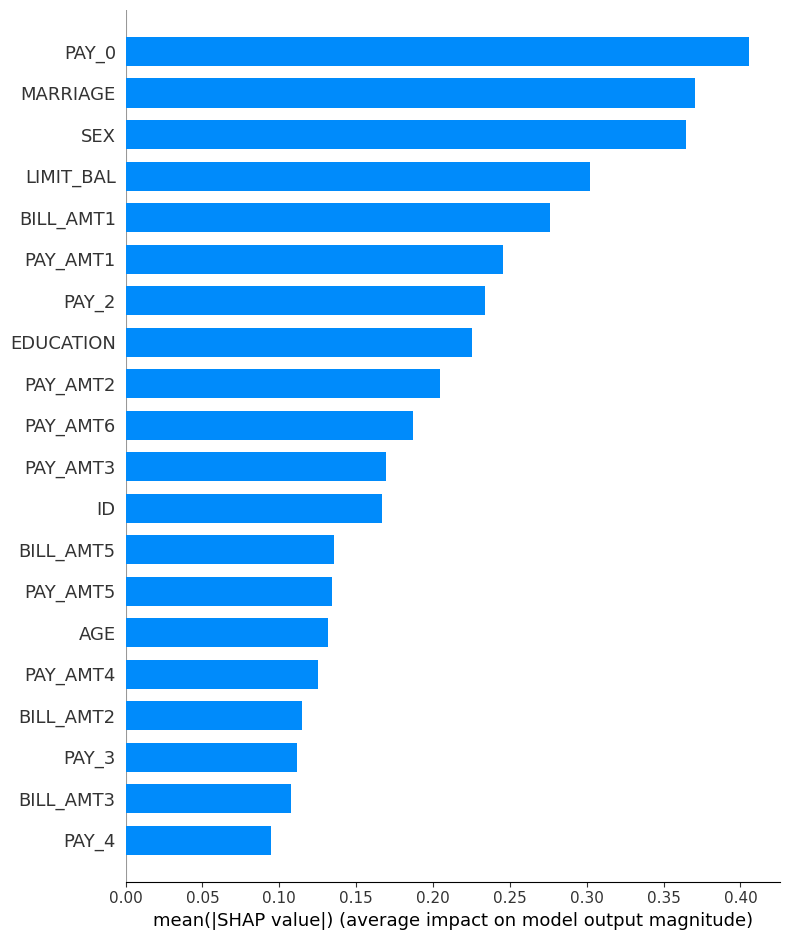

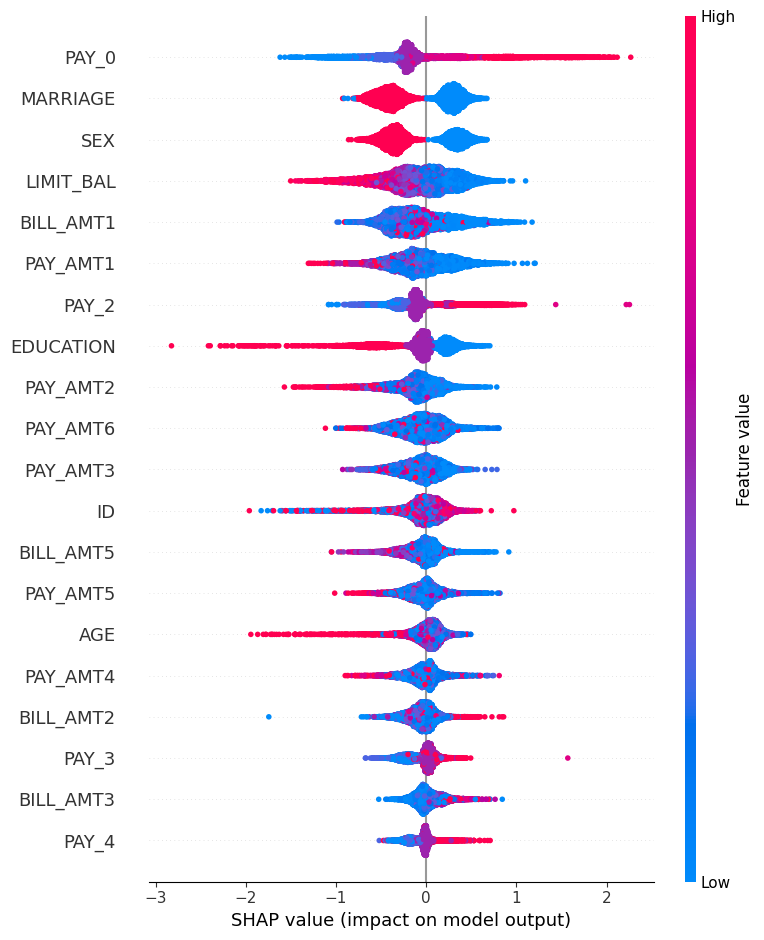

Individual Explanation for a Single Prediction


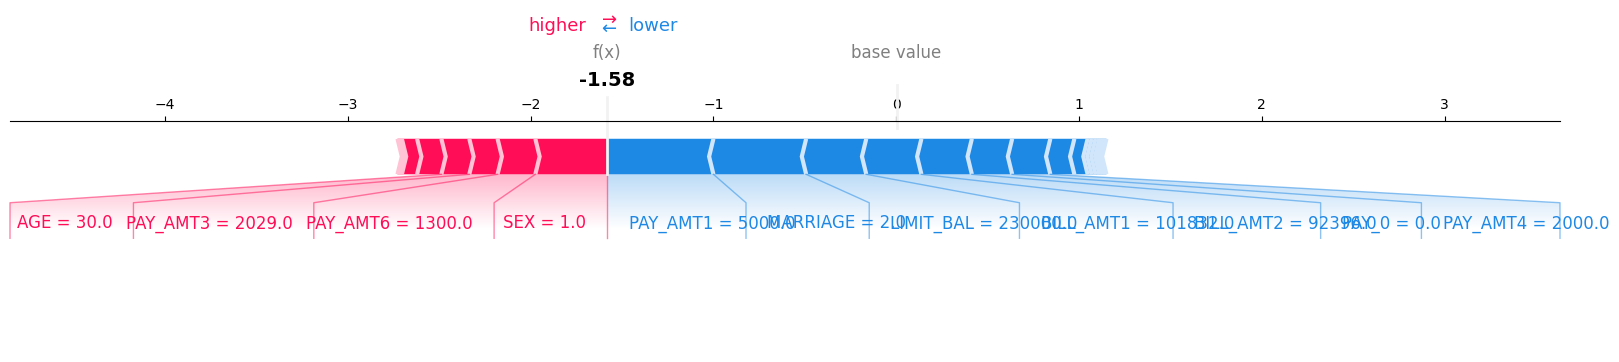

In [4]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer for XGBoost
explainer = shap.Explainer(model)

# Calculate SHAP values for the test dataset
shap_values = explainer(X_test)

# 1. Global Explanation: Feature Importance
print("Global Feature Importance")
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot for feature importance
shap.summary_plot(shap_values, X_test)  # Summary plot for overall feature impact

# 2. Individual Explanation: Force Plot for a Single Instance
# Individual Explanation: Force Plot for a Single Instance
print("Individual Explanation for a Single Prediction")
instance_index = 0  # Change this index to inspect different data points

# Access the expected value (base value)
base_value = explainer.expected_value

# For binary classification, expected_value is usually a single value
if isinstance(base_value, list) or isinstance(base_value, np.ndarray):
    base_value = base_value[1]  # Use the second class's base value if applicable

# Generate the force plot
shap.force_plot(
    base_value,
    shap_values[instance_index].values,
    X_test.iloc[instance_index],
    matplotlib=True
)


In [5]:
pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 5.2 MB/s eta 0:00:00


In [6]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score

# Define sensitive attribute (e.g., Gender)
sensitive_attribute = X_test['SEX']  # Assuming SEX is in the test set

# Define a basic metric (e.g., accuracy)
accuracy = accuracy_score(y_test, y_pred)

# Compute fairness metrics
metric_frame = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_attribute
)

# Display metrics for different groups
print("Fairness Metrics by Group:")
print(metric_frame.by_group)

# Compute specific fairness differences
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_attribute)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_attribute)

print(f"Demographic Parity Difference: {dp_diff}")
print(f"Equalized Odds Difference: {eo_diff}")


Fairness Metrics by Group:
     accuracy
SEX          
1    0.740949
2    0.801361
Demographic Parity Difference: 0.10454236832472547
Equalized Odds Difference: 0.10224570809919054


In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load the dataset
client_data = pd.read_csv("Client_Data.csv")

# Step 1: Handle Missing Values
# Replace missing values in numeric columns with median
numeric_columns = client_data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="median")
client_data[numeric_columns] = imputer.fit_transform(client_data[numeric_columns])

# Step 2: Handle Outliers
# Using IQR to cap outliers for numeric columns
Q1 = client_data[numeric_columns].quantile(0.25)
Q3 = client_data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Capping outliers
for col in numeric_columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    client_data[col] = np.clip(client_data[col], lower_bound, upper_bound)

# Step 3: Ensure Consistency in Categorical Variables
# Map unexpected values in categorical columns
client_data['EDUCATION'] = client_data['EDUCATION'].replace({0: 4, 5: 4, 6: 4})  # Combine unknowns
client_data['MARRIAGE'] = client_data['MARRIAGE'].replace({0: 3})  # Unknown category to "others"

# Step 4: Feature Engineering
# Average delay in payments
client_data['Avg_Delay'] = client_data[[f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in client_data.columns]].mean(axis=1)

# Total number of months with default
client_data['Total_Defaults'] = client_data[[f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in client_data.columns]].apply(
    lambda row: sum(row > 0), axis=1)

# Payment trends: Ratio of total payment amount to bill amount
client_data['Payment_Trend'] = client_data[[f'PAY_AMT{i}' for i in range(1, 7)]].sum(axis=1) / \
                               client_data[[f'BILL_AMT{i}' for i in range(1, 7)]].sum(axis=1)

# Replace infinities or NaNs in engineered features
client_data.replace([np.inf, -np.inf], np.nan, inplace=True)
client_data.fillna(0, inplace=True)

# Display the cleaned and feature-engineered dataset
print(client_data.head())


    ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0  1.0    20000.0  2.0        2.0       1.0  24.0    1.5    1.5   -1.0   -1.0   
1  2.0   120000.0  2.0        2.0       2.0  26.0   -1.0    1.5    0.0    0.0   
2  3.0    90000.0  2.0        2.0       2.0  34.0    0.0    0.0    0.0    0.0   
3  4.0    50000.0  2.0        2.0       1.0  37.0    0.0    0.0    0.0    0.0   
4  5.0    50000.0  1.0        2.0       1.0  57.0   -1.0    0.0   -1.0    0.0   

   ...  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0  ...       0.0     689.0       0.0       0.0       0.0       0.0   
1  ...       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2  ...    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3  ...    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
4  ...    2000.0   11250.5   10000.0    9000.0     689.0     679.0   

   default payment next month  Avg_Delay  Total_Defaults  Payment_Trend  
0                 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
client_data = pd.read_csv("Client_Data.csv")


                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802

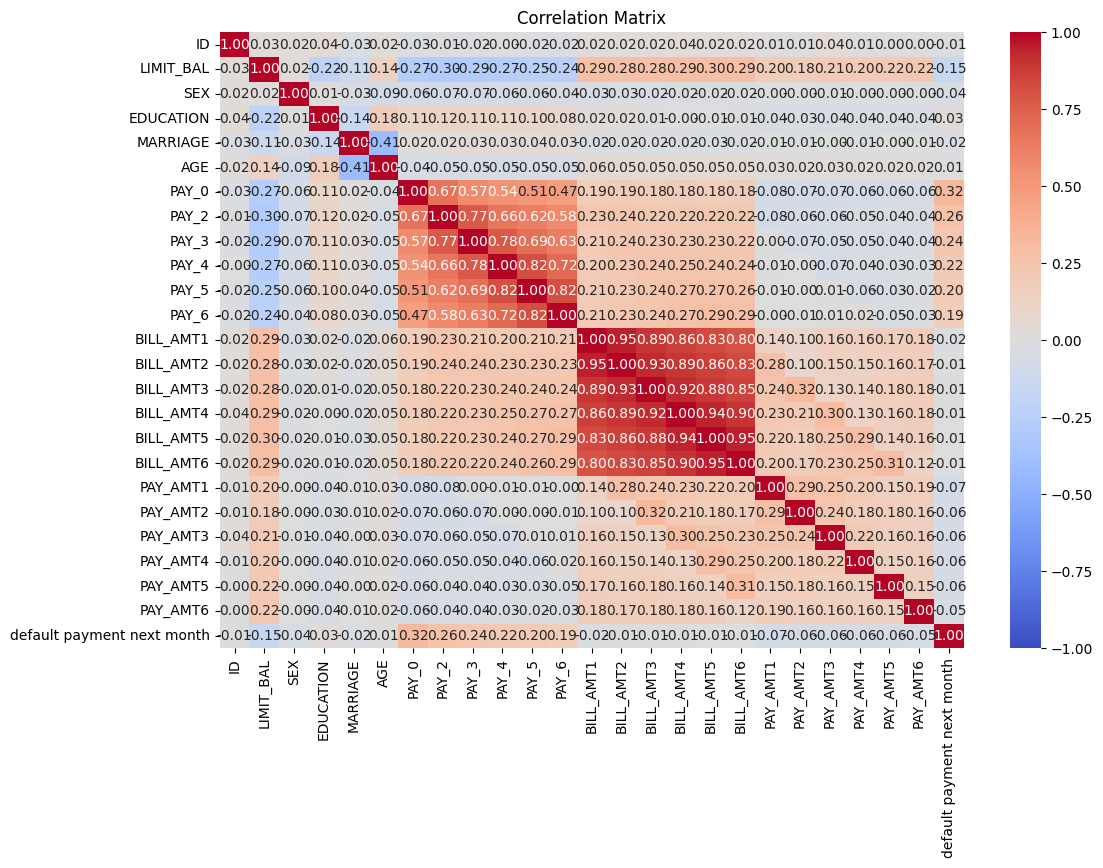

In [10]:
# Display summary statistics
print(client_data.describe())

# Correlation matrix
corr_matrix = client_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [12]:
# Ensure Avg_Delay is created correctly
client_data['Avg_Delay'] = client_data[[f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in client_data.columns]].mean(axis=1)

# Verify if the column is now present
print(client_data[['Avg_Delay']].head())


   Avg_Delay
0  -0.333333
1   0.500000
2   0.000000
3   0.000000
4  -0.333333


In [14]:
# Ensure Payment_Trend is calculated
client_data['Payment_Trend'] = client_data[[f'PAY_AMT{i}' for i in range(1, 7)]].sum(axis=1) / \
                               client_data[[f'BILL_AMT{i}' for i in range(1, 7)]].sum(axis=1)

# Verify if the column is now present
print(client_data[['Payment_Trend']].head())


   Payment_Trend
0       0.089434
1       0.292791
2       0.108388
3       0.036259
4       0.540054


<ipython-input-15-a3064b2395bc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=client_data["default payment next month"], y=client_data["Avg_Delay"], palette="Set2")


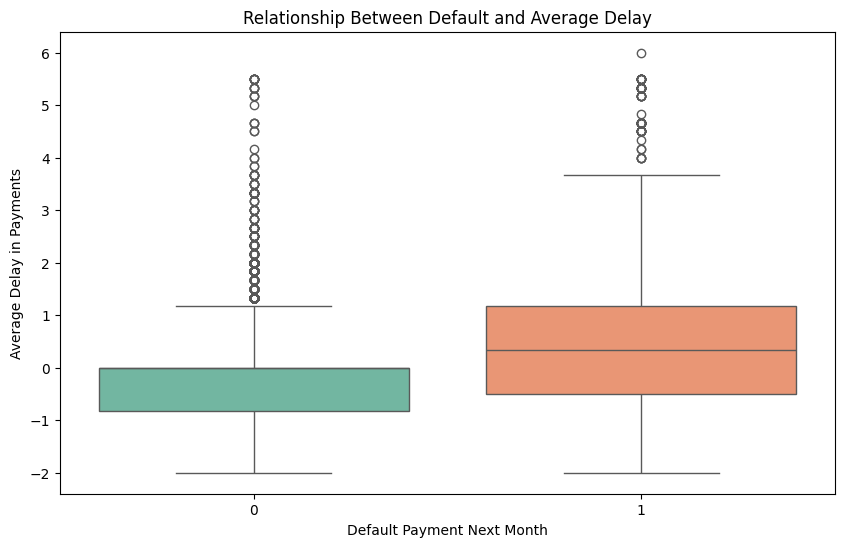

<ipython-input-15-a3064b2395bc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=client_data["default payment next month"], y=client_data["Payment_Trend"], palette="Set1")


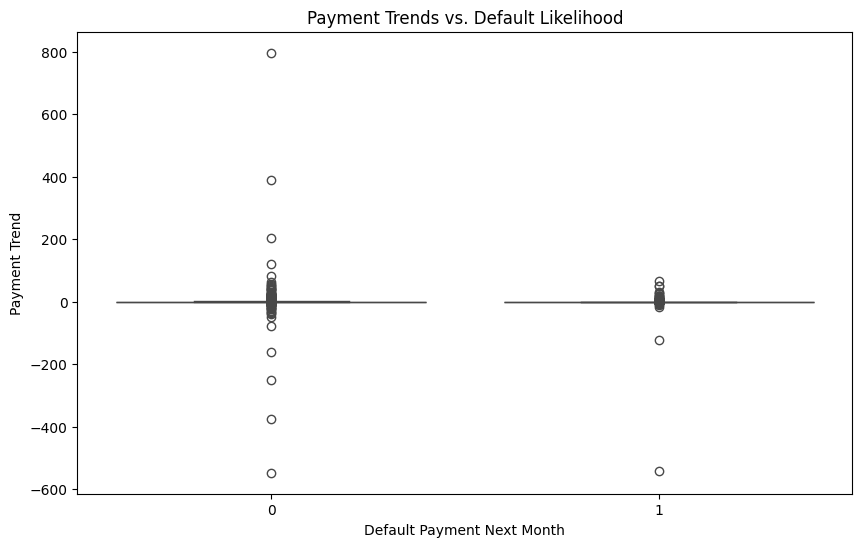

In [15]:
# Default rate by average delay
plt.figure(figsize=(10, 6))
sns.boxplot(x=client_data["default payment next month"], y=client_data["Avg_Delay"], palette="Set2")
plt.title("Relationship Between Default and Average Delay")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Average Delay in Payments")
plt.show()

# Payment trends vs. default
plt.figure(figsize=(10, 6))
sns.boxplot(x=client_data["default payment next month"], y=client_data["Payment_Trend"], palette="Set1")
plt.title("Payment Trends vs. Default Likelihood")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Payment Trend")
plt.show()


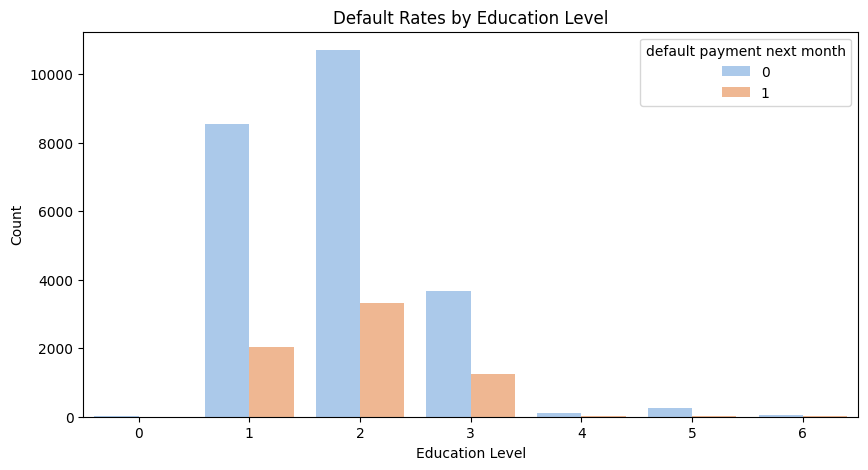

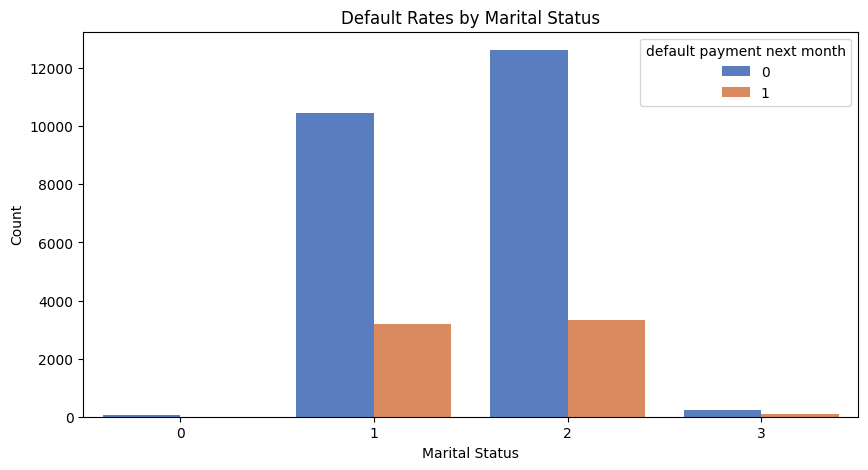

In [16]:
# Default rate by education level
plt.figure(figsize=(10, 5))
sns.countplot(x="EDUCATION", hue="default payment next month", data=client_data, palette="pastel")
plt.title("Default Rates by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

# Default rate by marital status
plt.figure(figsize=(10, 5))
sns.countplot(x="MARRIAGE", hue="default payment next month", data=client_data, palette="muted")
plt.title("Default Rates by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load cleaned dataset
client_data = pd.read_csv("Client_Data.csv")

# Separate features and target
X = client_data.drop(columns=["default payment next month"])
y = client_data["default payment next month"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to address class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features (important for algorithms like Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [20]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss", random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:20:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      7009
           1       0.50      0.46      0.48      1991

    accuracy                           0.78      9000
   macro avg       0.67      0.66      0.67      9000
weighted avg       0.77      0.78      0.77      9000

XGBoost AUC-ROC Score: 0.739277311462718


In [21]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba_rf))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      7009
           1       0.52      0.48      0.50      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.68      0.68      9000
weighted avg       0.78      0.79      0.79      9000

Random Forest AUC-ROC Score: 0.7503700666410172


In [22]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for the trained XGBoost model
explainer = shap.Explainer(xgb_model, X_train_scaled)

# Compute SHAP values for the test dataset
shap_values = explainer(X_test_scaled)


 99%|===================| 8877/9000 [00:49<00:00]       

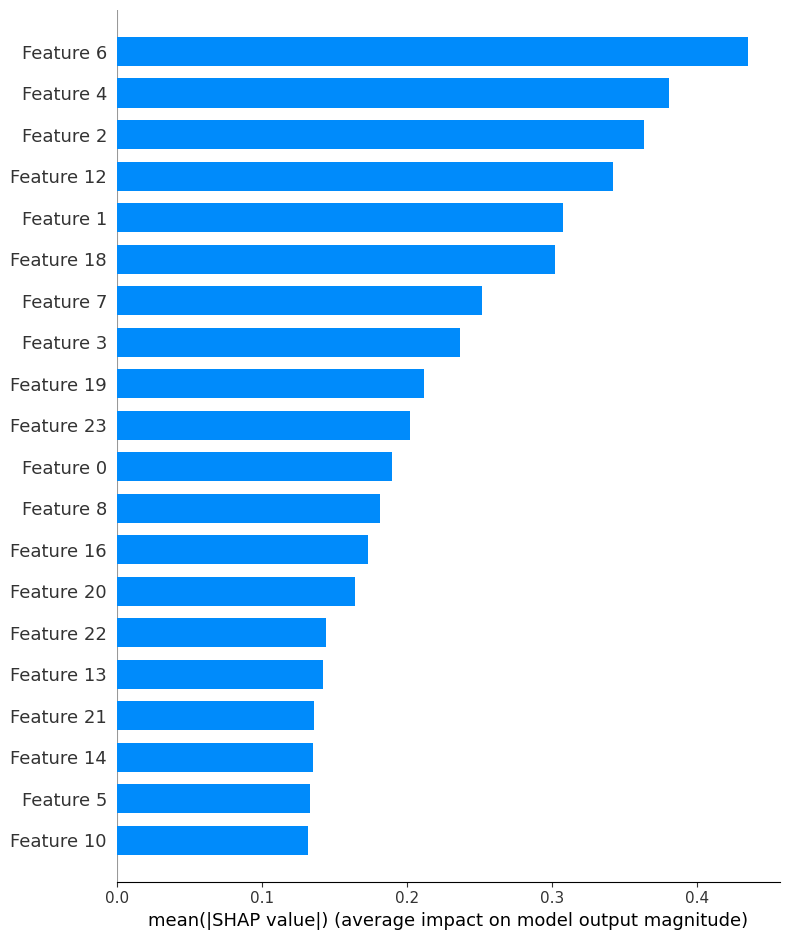

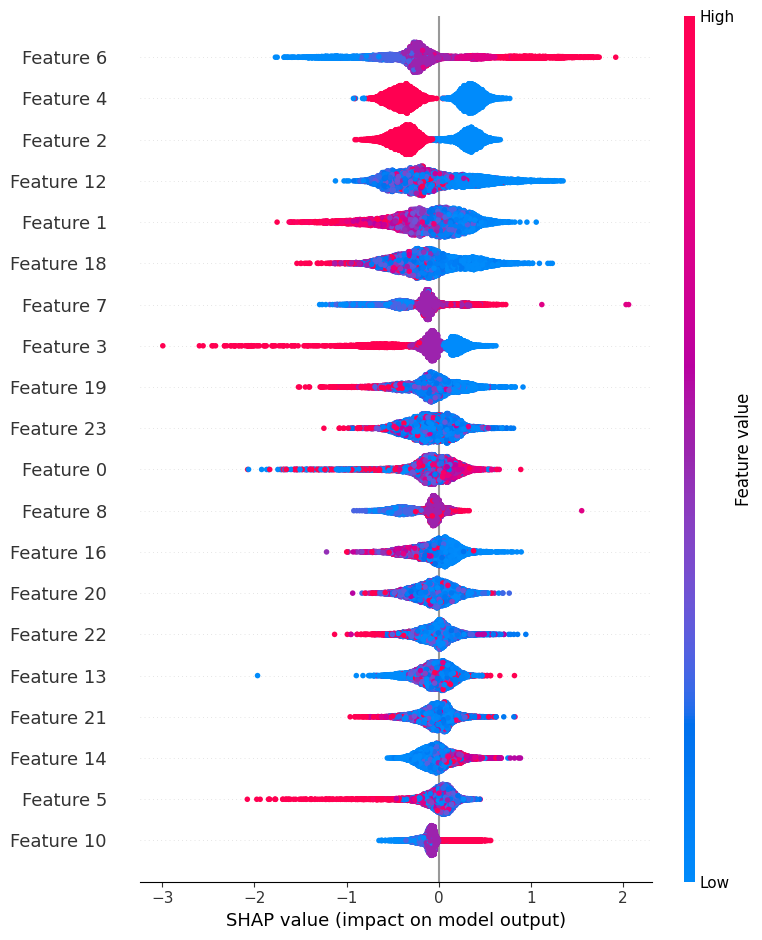

In [23]:
# Summary plot (bar plot for feature importance)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

# Summary plot (detailed feature contributions)
shap.summary_plot(shap_values, X_test_scaled)


In [26]:
print(X_test_scaled_df.columns)


Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


 99%|===================| 8939/9000 [00:46<00:00]       

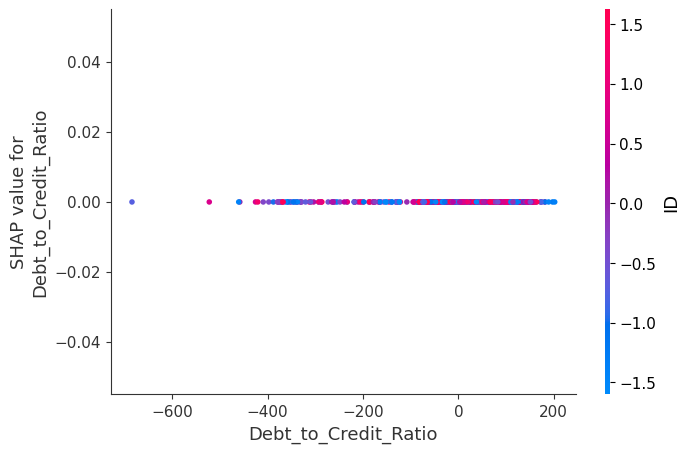

In [28]:
# Reinitialize SHAP explainer with the updated dataset
explainer = shap.Explainer(xgb_model, X_test_scaled_df)

# Recompute SHAP values for the updated dataset
shap_values = explainer(X_test_scaled_df)

# Dependence plot for Debt_to_Credit_Ratio
shap.dependence_plot(
    "Debt_to_Credit_Ratio",
    shap_values.values,
    X_test_scaled_df
)



In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


In [30]:
# Load preprocessed dataset
client_data = pd.read_csv("Client_Data.csv")

# Separate features and target
X = client_data.drop(columns=["default payment next month"])
y = client_data["default payment next month"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Initialize models
models = {
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42)
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"--- {name} ---")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("\n")


--- XGBoost ---
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      7009
           1       0.50      0.46      0.48      1991

    accuracy                           0.78      9000
   macro avg       0.67      0.66      0.67      9000
weighted avg       0.77      0.78      0.77      9000

ROC-AUC Score: 0.739277311462718


--- Random Forest ---
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      7009
           1       0.52      0.48      0.50      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.68      0.68      9000
weighted avg       0.78      0.79      0.79      9000

ROC-AUC Score: 0.7503700666410172


--- Logistic Regression ---
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78      7009
           1       0.37     

KeyboardInterrupt: 

In [32]:
# Example: GridSearch for XGBoost
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "scale_pos_weight": [1, 2, 3]
}

grid_search = GridSearchCV(
    XGBClassifier(eval_metric="logloss", random_state=42),
    param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_scaled)
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
print("Best XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}
Best XGBoost ROC-AUC: 0.7424516043410929


In [33]:
# Cross-validation for the best model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_xgb_model, X_train_scaled, y_train_resampled, cv=cv, scoring="roc_auc")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [0.92164137 0.92749275 0.92838846 0.92450236 0.91904404]
Mean CV Score: 0.9242137977114879


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      7009
           1       0.51      0.45      0.48      1991

    accuracy                           0.78      9000
   macro avg       0.68      0.66      0.67      9000
weighted avg       0.77      0.78      0.78      9000



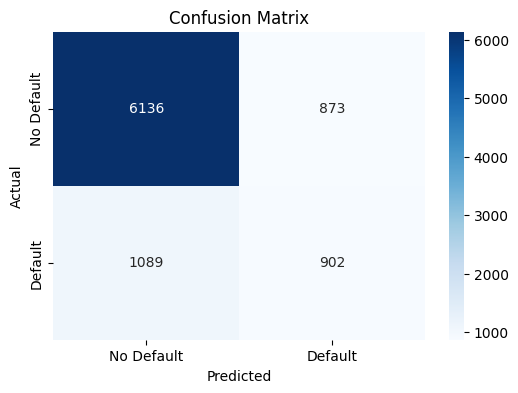

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on test data
y_pred = best_xgb_model.predict(X_test_scaled)
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


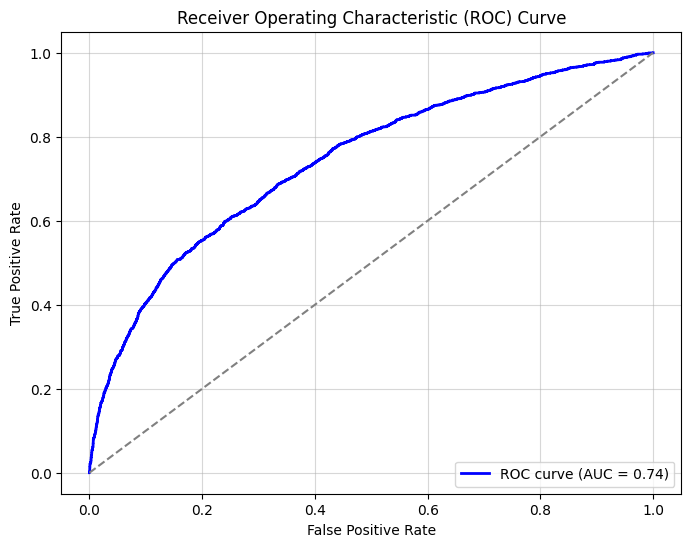

In [35]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random model
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()


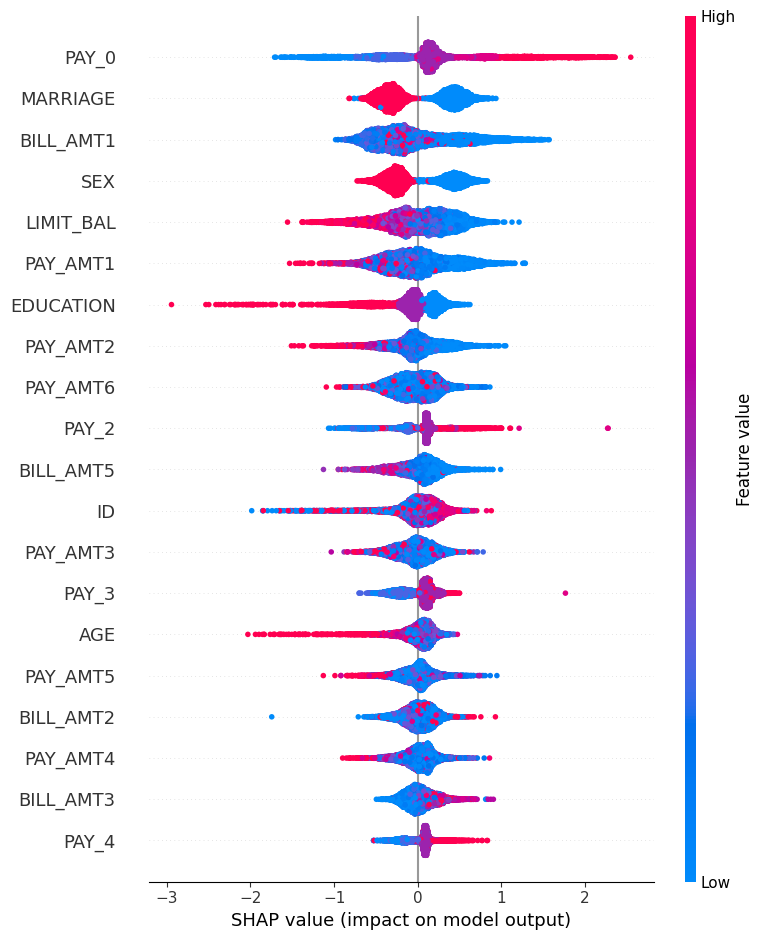

Top Influential Features: Index(['PAY_0', 'MARRIAGE', 'BILL_AMT1', 'SEX', 'LIMIT_BAL', 'PAY_AMT1',
       'EDUCATION', 'PAY_AMT2', 'PAY_AMT6', 'PAY_2'],
      dtype='object')


In [36]:
# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled_df)

# List the most influential features
important_features = X_test_scaled_df.columns[np.argsort(np.abs(shap_values.values).mean(axis=0))[::-1]]
print("Top Influential Features:", important_features[:10])


In [39]:
# Convert scaled datasets back to DataFrames with original feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Verify the DataFrame columns
print("Columns in X_train_scaled_df:", X_train_scaled_df.columns)
# Select the top 10 features identified by SHAP
top_features = important_features[:10]

# Create new datasets with only top features
X_train_adjusted = X_train_scaled_df[top_features]
X_test_adjusted = X_test_scaled_df[top_features]

# Verify adjusted datasets
print("Top features in adjusted training set:", X_train_adjusted.columns)



Columns in X_train_scaled_df: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Top features in adjusted training set: Index(['PAY_0', 'MARRIAGE', 'BILL_AMT1', 'SEX', 'LIMIT_BAL', 'PAY_AMT1',
       'EDUCATION', 'PAY_AMT2', 'PAY_AMT6', 'PAY_2'],
      dtype='object')


In [40]:
# Train XGBoost on the adjusted dataset
xgb_model_adjusted = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model_adjusted.fit(X_train_adjusted, y_train_resampled)

# Evaluate the adjusted model
y_pred_adjusted = xgb_model_adjusted.predict(X_test_adjusted)
y_pred_proba_adjusted = xgb_model_adjusted.predict_proba(X_test_adjusted)[:, 1]

print("Classification Report (Adjusted):\n", classification_report(y_test, y_pred_adjusted))
print("ROC-AUC Score (Adjusted):", roc_auc_score(y_test, y_pred_proba_adjusted))


Classification Report (Adjusted):
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      7009
           1       0.45      0.49      0.47      1991

    accuracy                           0.76      9000
   macro avg       0.65      0.66      0.66      9000
weighted avg       0.76      0.76      0.76      9000

ROC-AUC Score (Adjusted): 0.7309190759186779


In [43]:
# Recompute Debt_to_Credit_Ratio for training and test datasets
X_train["Debt_to_Credit_Ratio"] = X_train[[f"BILL_AMT{i}" for i in range(1, 7)]].sum(axis=1) / X_train["LIMIT_BAL"]
X_test["Debt_to_Credit_Ratio"] = X_test[[f"BILL_AMT{i}" for i in range(1, 7)]].sum(axis=1) / X_test["LIMIT_BAL"]

# Verify that the feature is added
print("Columns in X_train after adding Debt_to_Credit_Ratio:", X_train.columns)
print("Columns in X_test after adding Debt_to_Credit_Ratio:", X_test.columns)
# Re-scale the features, including the newly added 'Debt_to_Credit_Ratio'
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames with original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Verify that 'Debt_to_Credit_Ratio' is now present in the scaled DataFrames
print("Columns in X_train_scaled_df:", X_train_scaled_df.columns)
print("Columns in X_test_scaled_df:", X_test_scaled_df.columns)




Columns in X_train after adding Debt_to_Credit_Ratio: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'Debt_to_Credit_Ratio'],
      dtype='object')
Columns in X_test after adding Debt_to_Credit_Ratio: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'Debt_to_Credit_Ratio'],
      dtype='object')
Columns in X_train_scaled_df: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BI